In [1]:
%load_ext lab_black
import pandas as pd
import json
import requests
import numpy as np

from config import g_key
from config import mapbox_token

import plotly.express as px

# Part II : VacationPy
----


## Loading in CSV

In [2]:
city_data_to_load = "Resources/city_result.csv"

city_data = pd.read_csv(city_data_to_load)
df = city_data
df.head(2)

,Unnamed: 0,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,Bambous Virieux,-20.34,57.76,75.2,60,40,6.93,MU,1600869990
1,1,Barrow,71.29,-156.79,30.2,68,90,6.93,US,1600869902


In [3]:
# Adding a new column to the DataFrame that will house the Lat and Lon together as a string.

df["Lat_Lon"] = df["Lat"].astype(str) + "," + df["Lon"].astype(str)
df.head(2)

,Unnamed: 0,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date,Lat_Lon
0,0,Bambous Virieux,-20.34,57.76,75.2,60,40,6.93,MU,1600869990,"-20.34,57.76"
1,1,Barrow,71.29,-156.79,30.2,68,90,6.93,US,1600869902,"71.29,-156.79"


In [4]:
# Dropping unnecessary columns.
df.drop(columns=["Unnamed: 0", "Date"], inplace=True)

In [5]:
# Filtering DataFrame to display only those cities with ideal weather conditions.
perfect_weather_df = df[
    (df["Max Temp"] <= 80)
    & (df["Max Temp"] >= 60)
    & (df["Wind Speed"] <= 20)
    & (df["Cloudiness"] <= 30)
]
perfect_weather_df.head(2)

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Lat_Lon
7,Rikitea,-23.12,-134.97,71.92,73,1,13.85,PF,"-23.12,-134.97"
8,Aksu,41.12,80.26,70.07,25,0,3.09,CN,"41.12,80.26"


In [6]:
perfect_weather_df["Lat_Lon"].value_counts().sum()

85

In [7]:
lat_lon_list = perfect_weather_df["Lat_Lon"].tolist()

In [8]:
# Creating the API request and testing it by creating a Json for a single city from the list I created above.
hotels = requests.get(
    "https://maps.googleapis.com/maps/api/place/nearbysearch/json",
    params={
        "key": g_key,
        "location": lat_lon_list[17],
        "radius": "5000",
        "type": "lodging",
    },
).json()

In [9]:
hotels

{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
   'geometry': {'location': {'lat': 41.4113711, 'lng': -73.4152646},
    'viewport': {'northeast': {'lat': 41.4126229802915,
      'lng': -73.4140460697085},
     'southwest': {'lat': 41.4099250197085, 'lng': -73.41674403029151}}},
   'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
   'name': 'Courtyard by Marriott Danbury',
   'opening_hours': {'open_now': True},
   'photos': [{'height': 4000,
     'html_attributions': ['<a href="https://maps.google.com/maps/contrib/105731878337185886845">Courtyard by Marriott Danbury</a>'],
     'photo_reference': 'CmRaAAAAgYCZ8PqJ12EIUv6DnWTN8F0BnUCMuXa_MHs2GLqD1l677ryX39yQusSxmSS67PU9n1fchIVQDEP96RVWnOWWKHmdmzwmO5nkk7ET7a_JMl6ShWC1MIH1n2eIr2f5LW_TEhDebiG17w093qvmRC_h59XJGhRAJ9m7gqwMhAyM8b-ITahklrFZ3g',
     'width': 5993}],
   'place_id': 'ChIJFUu_ndf-54kRPT9YW753kqA',
   'plus_code': {'compound_code': 'CH6M+GV Danbury, CT, USA',
    'global_code':

In [10]:
# Function to extract data for the first hotel for each city.
def extract_data(data):
    data = data["results"][0]
    return {
        "Hotel Name": data["name"],
        "Lat": data["geometry"]["location"]["lat"],
        "Lon": data["geometry"]["location"]["lng"],
    }

In [11]:
# Creating Blank List and iterating and printing latitude and longitude values to confirm what's values are being inserted in my params.
hotel_results = []

print("Beginning Data Retrieval")
print("----------------------------------------")

for lat_lon in lat_lon_list:
    try:
        print(lat_lon)
        data = requests.get(
            "https://maps.googleapis.com/maps/api/place/nearbysearch/json",
            params={
                "key": g_key,
                "location": lat_lon,
                "radius": "5000",
                "type": "lodging",
            },
        ).json()
        hotel_result = extract_data(data)
        hotel_results.append(hotel_result)
    except Exception as e:
        print(e)
        print(f"{lat_lon} Not found. Skipping...")
        continue
print("----------------------------------------")
print("Data Retrieval Complete")
print("----------------------------------------")

Beginning Data Retrieval
----------------------------------------
-23.12,-134.97
41.12,80.26
57.97,33.25
42.1,-79.24
-34.42,19.23
-16.48,-151.75
43.48,-8.24
46.87,42.06
-33.93,18.42
-15.2,12.15
-21.2,-175.2
-25.24,130.99
-19.55,169.27
-33.65,115.33
-33.02,27.91
-34.53,20.04
-8.93,125.41
41.37,-73.41
47.38,28.82
-26.65,15.16
-25.4,-70.48
28.66,-17.92
-31.4,26.36
-29.62,-54.18
59.7,30.79
-33.59,26.89
-32.55,115.7
-35.33,-72.42
-33.01,17.94
9.3,13.4
-28.55,16.43
-28.78,32.04
54.17,17.49
-30.18,-50.21
37.61,-122.49
-23.25,-50.98
30.48,-115.95
40.66,-73.58
56.89,21.19
17.96,-102.2
20.89,-156.47
42.91,73.27
59.78,30.82
37.1,-113.58
-22.96,14.51
28.12,-16.73
35.15,-114.57
44.51,50.26
-14.83,-64.9
26.59,127.98
-6.6,147.87
47.57,26.2
-34.0,24.73
-25.86,26.9
-19.84,34.84
-20.28,44.28
-33.92,25.57
-13.85,136.42
-17.73,-149.15
41.14,-73.36
43.75,-81.72
45.32,55.2
30.37,-88.56
42.56,-114.46
31.55,-110.3
41.71,-70.23
32.68,109.02
-20.74,116.85
54.08,21.38
-20.73,139.5
8.27,-80.55
-17.53,-149.33
31.2

In [13]:
# Converting returned dictionaries to a DataFrame
hotel_results_df = pd.DataFrame.from_dict(hotel_results)
hotel_results_df

,Hotel Name,Lat,Lon
0,Pension Maro'i,-23.120620,-134.968753
1,Pudong Holiday Hotel,41.141760,80.291396
2,"Valdayskiye Zori, Gostinichno-Restorannyy Komp...",57.974286,33.268093
3,Hampton Inn & Suites Jamestown,42.118457,-79.242773
4,Misty Waves Boutique Hotel,-34.421390,19.236641
...,...,...,...
77,"ŠVIESA, svečių namai, UAB LAZDYNO RIEŠUTAS",55.132678,26.159317
78,Veranda Paul et Virginie Hotel & Spa,-20.006569,57.668077
79,Wedgewood Motel,42.148391,-72.305276
80,Holiday Inn Express Roseville-St. Paul,45.022670,-93.193242


In [14]:
# Rounding decimals for latitude and longitude so I can use them to merge the hotel DataFrame with the perfect weather DataFrame.
hotel_results_round_df = hotel_results_df.round(decimals=1)
hotel_results_round_df.head(2)

,Hotel Name,Lat,Lon
0,Pension Maro'i,-23.1,-135.0
1,Pudong Holiday Hotel,41.1,80.3


In [15]:
perfect_weather_round_df = perfect_weather_df.round(decimals=1)
perfect_weather_round_df.drop(columns=["Lat_Lon"], inplace=True)
perfect_weather_round_df.head(2)

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country
7,Rikitea,-23.1,-135.0,71.9,73,1,13.8,PF
8,Aksu,41.1,80.3,70.1,25,0,3.1,CN


In [16]:
map_df = pd.merge(hotel_results_round_df, perfect_weather_round_df, on="Lon")
map_df

,Hotel Name,Lat_x,Lon,City,Lat_y,Max Temp,Humidity,Cloudiness,Wind Speed,Country
0,Pension Maro'i,-23.1,-135.0,Rikitea,-23.1,71.9,73,1,13.8,PF
1,Pudong Holiday Hotel,41.1,80.3,Aksu,41.1,70.1,25,0,3.1,CN
2,Hampton Inn & Suites Jamestown,42.1,-79.2,Jamestown,42.1,60.0,81,1,8.1,US
3,Misty Waves Boutique Hotel,-34.4,19.2,Hermanus,-34.4,67.0,70,0,6.0,ZA
4,Bora-Bora Pearl Beach Resort & Spa,-16.5,-151.8,Faanui,-16.5,78.8,79,4,16.3,PF
...,...,...,...,...,...,...,...,...,...,...
77,Hotel Lahnblick,50.9,8.4,Bad Laasphe,50.9,72.0,42,0,15.0,DE
78,Gîte kajeon,-20.2,164.0,Poum,-20.2,72.3,77,10,8.6,NC
79,Veranda Paul et Virginie Hotel & Spa,-20.0,57.7,Grand Gaube,-20.0,73.0,66,0,7.0,MU
80,Wedgewood Motel,42.1,-72.3,Palmer,42.2,63.0,62,1,8.2,US


In [17]:
# Setting MapBox token.
px.set_mapbox_access_token(mapbox_token)

In [47]:
# Generating scatter map.
fig = px.scatter_mapbox(
    map_df,
    lat="Lat_x",
    lon="Lon",
    color="Humidity",
    title="Perfect Weather Vaction Spots w/ Hotels",
    hover_data=["Hotel Name", "City", "Country"],
    height=850,
    width=1300,
)

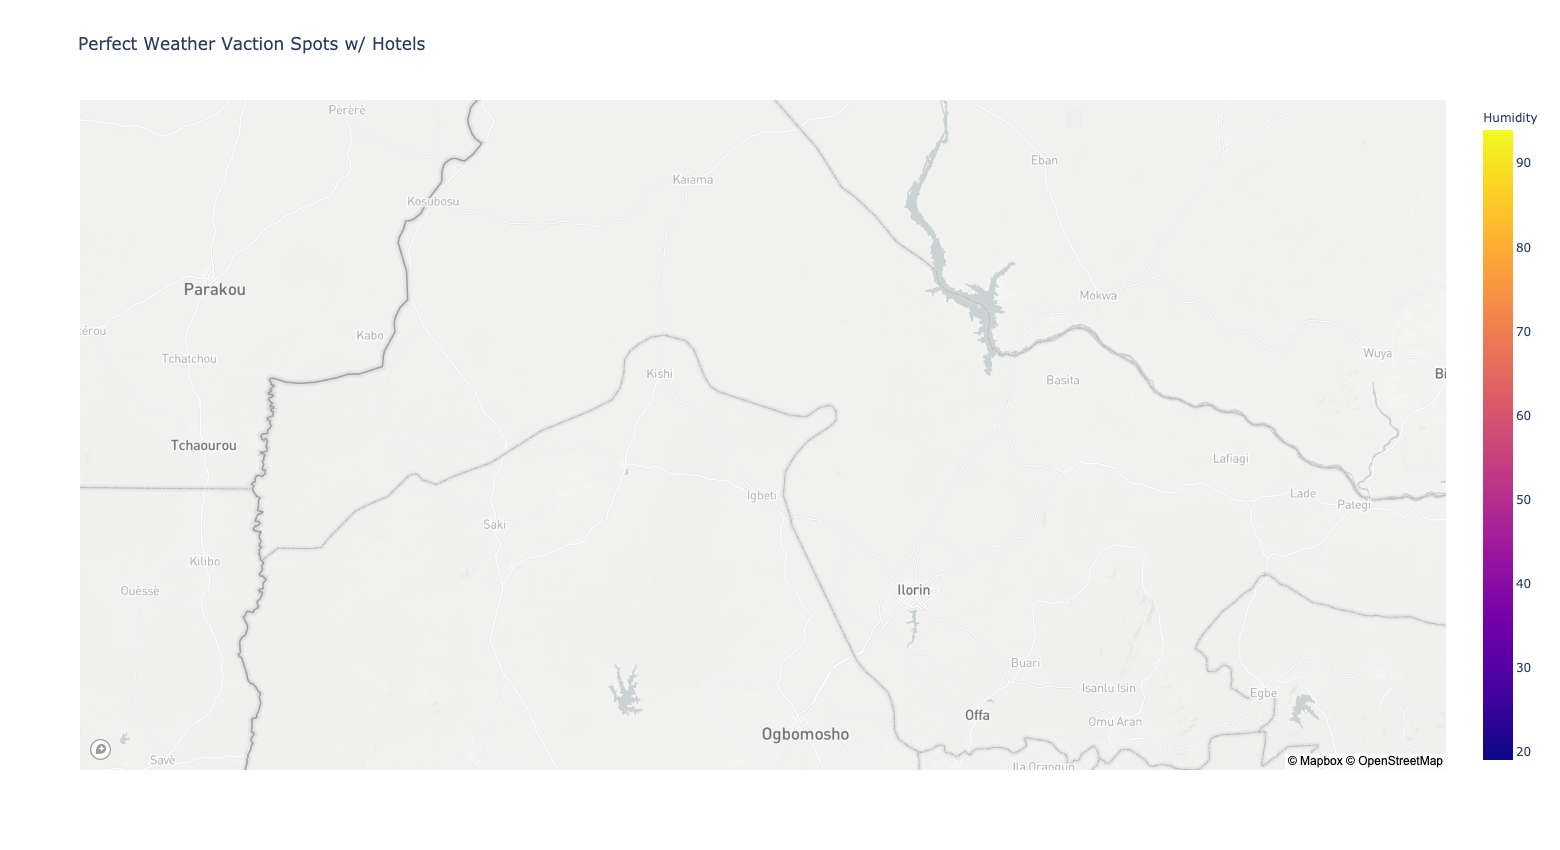

In [48]:
fig.show()